# MCMC 2.1: application for parameter estimation

In this notebook, we will use a Markov Chain based on the Metropolis-Hastings algorithm to estimate neutrino oscillation parameters.

The experiment setup simulated in this notebook is the one of the Deep Underground Neutrino Experiment (DUNE). DUNE measures neutrino oscillations by observing the transition of a muon (anti)neutrino beam created in Fermilab toward electron and tau (antineutrinos) in the far detector located 1'300 km away, in the Sanford Underground Research Facility. 

In [1]:
### Import necessary python packages

# math package
import numpy as np

# plotting packages
import matplotlib as mpl
from matplotlib import pyplot as plt

# input files reading package 
import json

# data container package
import pandas as pd


# get the time
from datetime import datetime
import time

import emcee


In [2]:
### Setup plot options

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


## 1. Obtain the neutrino flux

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [3]:
### Function to read a JSON with several dictionaries separated by a new line

def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)


In [4]:
### Read JSON file

flux_file = "dune_flux_hist.json"

flux_data = list(json_reader(flux_file))
len(flux_data), flux_data[0].keys()


(144,
 dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title']))

### 1.1 Unoscillated event rate

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [5]:
### Select dictionary for FD, neutrino mode, muon neutrino unoscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = ''

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_unosc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_unosc = flux_data_numode_fd_numu_ccrate_unosc[0]
evt_rate_unosc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

In [6]:
### Select dictionary for FD, neutrino mode, muon neutrino oscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = 'osc'

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_osc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_osc = flux_data_numode_fd_numu_ccrate_osc[0]
evt_rate_osc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

In [7]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Affiche une barre de progression dans la console.
    
    :param iteration: Itération actuelle (int)
    :param total: Total des itérations (int)
    :param prefix: Préfixe de la barre (str)
    :param suffix: Suffixe de la barre (str)
    :param decimals: Nombre de décimales dans le pourcentage (int)
    :param length: Longueur de la barre de progression (int)
    :param fill: Caractère de remplissage de la barre (str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()

### 1.2 Oscillated event rate

We will use as model the simplified case of 2 neutrino flavours, the neutrino oscillation "appearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_e} \ = \ \sin^2 (2\theta) \ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) $$
with: 
$$ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) \ \simeq \ \sin^2 \left( 1.27 \frac{\Delta m^2 [eV^2] \ L[km]}{E[GeV]} \right) $$
so the "disappearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_{\mu}} \ = 1 - P_{\nu_{\mu} \rightarrow \nu_e} $$

The oscillation parameters are the mixing angle $\theta$ and the square of mass difference $\Delta m^2$. We want to estimate them using the histograms that we extracted.

In [8]:
### Define the oscillation probability

def osc_proba(E, theta=np.pi/4, Dm2=2.2e-3, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [9]:
### Function to apply the oscillation to the unoscillated histogram 

def compute_osc_histo(theta, Dm2, hist): 

    # we will take the energy at the bin center
    bin_centers = []
    evt_rate_osc = [0]

    # loop over bins
    for i_b in np.arange(1, len(hist['bins'])):
        bin_centers.append(hist['bins'][i_b] - ((hist['bins'][i_b] - hist['bins'][i_b-1])/2))
        evt_rate_osc.append(hist['counts'][i_b] * osc_proba(bin_centers[-1], theta, Dm2))
    
    return evt_rate_osc

In [131]:
bin_centers=[]
for i_b in np.arange(0, len(evt_rate_unosc['bins'])):
        bin_centers.append(evt_rate_unosc['bins'][i_b] - ((evt_rate_unosc['bins'][i_b] - evt_rate_unosc['bins'][i_b-1])/2))


In [10]:
### Apply the oscillation to the unoscillated histogram and plot at the result

theta_true = np.pi/4
Dm2_true = 2.2e-3

evt_rate_osc_true = compute_osc_histo(theta_true, Dm2_true, evt_rate_unosc)


### 1.3 Compare the event rates

We will now compare the unoscillated and oscillated event rate. 

<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:24: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_7541/965627327.py:23: SyntaxWarning: invalid escape sequence '\ '
  ax.set_xlabel(r'$' + evt_rate_unosc['xaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
/tmp/ipykernel_7541/965627327.py:24: SyntaxWarning: invalid escape sequence '\ '
  ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)


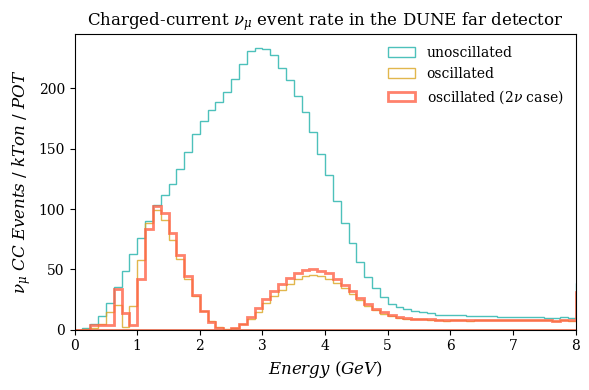

In [11]:
### Plot the fluxes

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(6,4), tight_layout=True)

# unoscillated rate from the DUNE ancillary file
ax.hist(evt_rate_unosc['bins'][:-1], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_unosc['counts'][:-1]],
        color=None, edgecolor='lightseagreen', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'unoscillated')

# oscillated rate from the DUNE ancillary file
ax.hist(evt_rate_osc['bins'][:-1], bins=evt_rate_osc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc['counts'][:-1]],
        color=None, edgecolor='goldenrod', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'oscillated')

# oscillated rate computed with the 2-neutrino formula
ax.hist(evt_rate_unosc['bins'], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc_true],
        color=None, edgecolor='tomato', fill=False, lw=2, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= r'oscillated (2$\nu$ case)')

# title and axes
ax.set_title(r'Charged-current $\nu_{\mu}$ event rate in the DUNE far detector')
ax.set_xlim([0, 8])
ax.set_xlabel(r'$' + evt_rate_unosc['xaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.legend(frameon=False)
plt.savefig('Simulated_Data')

## 2. Set up the Markov Chain

We will use a Markov Chain to sample the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC process at each step is: 
- throw a value of $\theta$ and $\Delta m^2$: $\{\theta_i, \Delta m^2_i \}$
- compute the oscillation probability for those parameter value at the DUNE energy $E_j$: $P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j)$
- apply the oscillation probability to the unoscillated histogram: $ N_{osc(i)}(E_j) =  N_{unosc}(E_j) \times P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j ) $
- compute the likelihood between the generated oscillated histogram and the one extracted from the file: 
- compute the Metropolis-Hastings ratio $r_i$ between the likelihood at this step and the likelihood at the previous step
- apply the acceptance function $A_i$
- redo until reaching the desired number of steps

### 2.1 Define the target distribution

The target distribution is the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC will sample:  
$$ P(\theta, \Delta m^2 | \vec{D}) = P(\vec{D} | \theta, \Delta m^2) \ P(\theta, \Delta m^2) $$
where 
- $ P(\theta, \Delta m^2 | \vec{D}) $ is the posterior probability 
- $ P(\vec{D} | \theta, \Delta m^2) $ is the likelihood 
- $P(\theta, \Delta m^2)$ is the prior probability on the parameters $\theta$ and  $\Delta m^2$ 

**2.1.1 Prior probability**

We use a uniform prior probability on $\theta$ and $\Delta m^2$: 
$$ P(\theta) = \sqcap(-\pi/2, \pi/2) $$
$$ P(\Delta m^2) = \sqcap(0, 0.01) $$

defined as: 
- $P(\theta) = 1$ if $\theta \in [-\pi/2, \pi/2]$
- $P(\Delta m^2) = 1$ if $\Delta m^2 \in [0, 10^{-2}]$
- $P(\theta, \Delta m^2) = 0$ elsewehere


In [112]:
### Prior on theta
def prior_theta(theta):
    if 0 <= theta <= np.pi/2 :
        return 1
    else :
        return 0


In [13]:
### Prior on Dm2
def prior_Dm2(Dm2):
    if 0 <= Dm2 <= 10**(-2) :
        return 1
    else :
        return 0


**2.1.2 Likelihood function**

As we compare histogram, we use $\mathcal{L}_i = exp(\ln(\mathcal{L}_i)) $ where $\ln(\mathcal{L}_i)$ is the log-likelihood ratio: 
$$-\ln(\mathcal{L}_i) = \sum_{j=1}^{N \ bins} N^H_{i,j}(\theta_i, \Delta m^2_i) -  N^D_{i,j} + N^D_{i,j} \ ln \left( \frac{N^D_{i,j}}{N^H_{i,j}(\theta_i, \Delta m^2_i)} \right) $$

with $N^D_{i,j}$ the number of event in each bin $j$ of the true histogram, and $N^H_{i,j}(\theta_i, \Delta m^2_i)$ the number of event in each bin $j$  of the computed histogram at this step $i$ 

In [78]:
### Compute the likelihood
LIK=[]
def likelihood(list):
    Likelihood=0
    for i in range(len(list)):
       if list[i] != 0 and evt_rate_osc_true[i] != 0:
            Likelihood += list[i] - evt_rate_osc_true[i] + evt_rate_osc_true[i]*np.log(evt_rate_osc_true[i]/list[i])
    LIK.append(Likelihood*20*1.47e21)
    return Likelihood*20*1.47e21

**2.1.3 Posterior probability**

We compute the unnormed posterior probability (ignoring the normalisation factor $1/P(D)$ as it cancelled out in the Metropolis-Hastings ratio): 
$$P(\theta_i, \Delta m^2_i | D)_{un} = \mathcal{L}_i \  P(\theta_i, \Delta m^2_i) $$

In [15]:
### Compute the posterior probability
def posterior_prob(likelihood,theta,Dm2):
    return np.exp(-likelihood)*prior_theta(theta)*prior_Dm2(Dm2)

### 2.2 Jump function

We throw a value of $\theta$ at the step $i$ with a multvariate normal jump function: 
$$J (\theta_ i, \Delta m^2_i | \theta_{i-1}, \Delta m^2_{i-1}) = \mathcal{N}(\{ \theta_{i-1},  \Delta m^2_{i-1} \} , \Sigma_{\theta, \Delta m^2})$$ 
where $\Sigma = diag(\sigma_{\theta}, \sigma_{\Delta m^2})$ is a matrix with diagonal values the step size for each sampled parameter, which value is chosen heuristically and strongly impacts the convergence speed of the chain.


In [16]:
### Compute the posterior probability
def Diag(sigma_theta,sigma_Dm2):
    Sigma = diagonal_matrix = np.diag([sigma_theta,sigma_Dm2])
    return Sigma
def Jump(sigma_theta,sigma_Dm2,theta_i_1,Dm2_i_1):
     return np.random.multivariate_normal([theta_i_1,Dm2_i_1], Diag(sigma_theta,sigma_Dm2))


In [17]:
### Define the oscillation probability

def osc_proba(E, theta, Dm2, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [44]:
sigma_theta = 0.5
sigma_Dm2 = 0.000000001

In [19]:
def metropolis0(steps,hist):

    current_state_theta = np.random.uniform(-np.pi/2,np.pi/2)
    current_state_Dm2 = 2.2e-3
    samples = []
    
    for i in range(steps):
        test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
        proposed_state_theta = test[0][0]
        print_progress_bar(i + 1, steps, prefix='Progress:', suffix='Complete', length=50)
        while prior_theta(proposed_state_theta) == 0 :
            test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
            proposed_state_theta = test[0][0]
        
        proposed_state_Dm2 = current_state_Dm2
        
        acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))
        
        if np.random.uniform(0,1) < acceptance_prob:
             current_state_theta = proposed_state_theta
             current_state_Dm2 = proposed_state_Dm2
             samples.append([current_state_theta,current_state_Dm2])
                
            
        else:
                 samples.append([current_state_theta,current_state_Dm2])
    
    return np.array(samples)

In [20]:
def metropolis1(steps,hist):

    current_state_theta = np.pi/4
    current_state_Dm2 = np.random.uniform(0,0.01)
    samples = []
    #rapport=[]
    for i in range(steps):
        test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
        proposed_state_Dm2 = test[0][1]
        print_progress_bar(i + 1, steps, prefix='Progress:', suffix='Complete', length=50)
        while prior_Dm2(proposed_state_Dm2) == 0 :
            test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
            proposed_state_Dm2 = test[0][1]

        proposed_state_theta = current_state_theta

        acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))
        
            #rapport.append(np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))
            
        if np.random.uniform(0,1) < acceptance_prob:
            current_state_theta = proposed_state_theta
            current_state_Dm2 = proposed_state_Dm2
            samples.append([current_state_theta,current_state_Dm2])
                
            
        else:
                samples.append([current_state_theta,current_state_Dm2])
    
    return np.array(samples)#,rapport

In [21]:
def metropolis(steps,hist):

    current_state_theta = np.random.uniform(-np.pi/2,np.pi/2)
    current_state_Dm2 = np.random.uniform(0,0.01)
    samples = []
    
    for i in range(steps):
        test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
        proposed_state_theta = test[0][0]
        proposed_state_Dm2 = test[0][1]
        print_progress_bar(i + 1, steps, prefix='Progress:', suffix='Complete', length=50)
        while prior_theta(proposed_state_theta) == 0 :
            test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
            proposed_state_theta = test[0][0]
        while prior_theta(proposed_state_Dm2) == 0 :
            test = np.random.multivariate_normal([current_state_theta,current_state_Dm2],Diag(sigma_theta,sigma_Dm2),1)
            proposed_state_Dm2 = test[0][1]
        
        
        acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))
        
        if np.random.uniform(0,1) < acceptance_prob:
             current_state_theta = proposed_state_theta
             current_state_Dm2 = proposed_state_Dm2
             samples.append([current_state_theta,current_state_Dm2])
                
            
        else:
                 samples.append([current_state_theta,current_state_Dm2])
    
    return np.array(samples)

### 2.3 Acceptance function

The acceptance function is: 
$$ A (\theta_{i}, \Delta m^2_i )=min\{1,r_{i} \} $$
where $r_{i}$ is the Metropolis-Hastings ratio.

**2.3.1 Metropolis-Hastings ratio** 

We compute the Metropolis-Hastings ratio $r_i$ between the posterior probability at this step and at the previous step: 
$$r_i =\frac{P(\theta_i, \Delta m^2_i | D)_{un} \ J(\theta_{i-1}, \Delta m^2_{i-1} | \theta_i, \Delta m^2_{i}) }{P(\theta_{i-1}, \Delta m^2_{i-1} | D)_{un} \ J(\theta_{i}, \Delta m^2_{i} | \theta_{i-1}, \Delta m^2_{i-1})} $$



In [114]:
%time Metro = metropolis(480000,evt_rate_unosc)

/tmp/ipykernel_7541/1350866593.py:20: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))


/tmp/ipykernel_7541/1350866593.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))


Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 8min 36s, sys: 5.44 s, total: 8min 42s
Wall time: 8min 40s


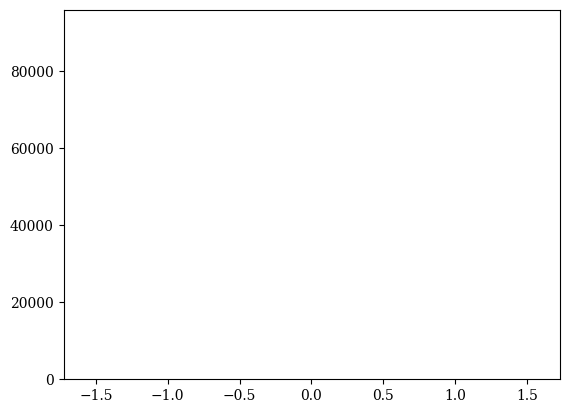

In [106]:
METRO = plt.hist(Metro,bins = 50000)

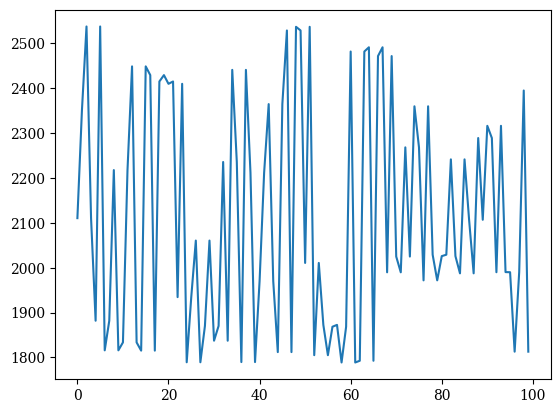

In [115]:
plt.plot(LIK[:100])

In [45]:
%time Metro0 = metropolis0(100000,evt_rate_unosc)

/tmp/ipykernel_7541/3245803765.py:17: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))
/tmp/ipykernel_7541/3245803765.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))


Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 2min, sys: 1.4 s, total: 2min 1s
Wall time: 2min 1s


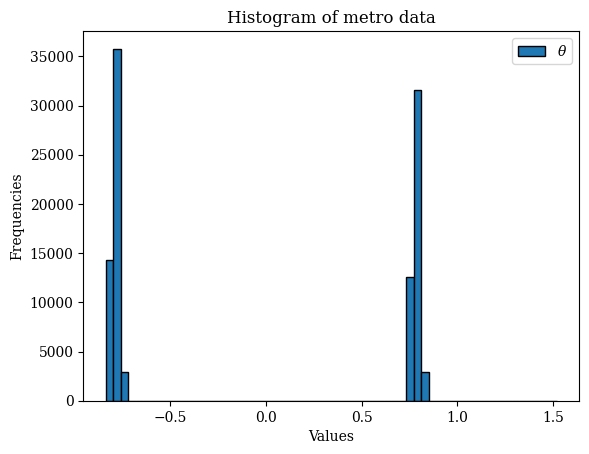

In [61]:
Metro_0= plt.hist([m[0] for m in Metro0], bins=60, edgecolor='black', label=[r'$\theta$'])
# Ajouter des titres et des étiquettes
plt.title('Histogram of metro data')
plt.xlabel('Values')
plt.ylabel('Frequencies')

# Définir les limites de l'axe des abscisses

plt.legend()
# Afficher l'histogramme
plt.savefig('Histo de theta_100000.png')
plt.show()

On voit ici qu'il y a 2 solutions, symétrie du système.

In [93]:
Metro1 = metropolis1(1000000,evt_rate_unosc)#[0]

/tmp/ipykernel_7541/1140434739.py:17: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_prob = min(1, np.exp(-likelihood(compute_osc_histo(proposed_state_theta, proposed_state_Dm2, hist)))/ np.exp(-likelihood(compute_osc_histo(current_state_theta, current_state_Dm2,hist ))))


KeyboardInterrupt: 

In [100]:
Metro1[1][1]

0.0004147401223803784

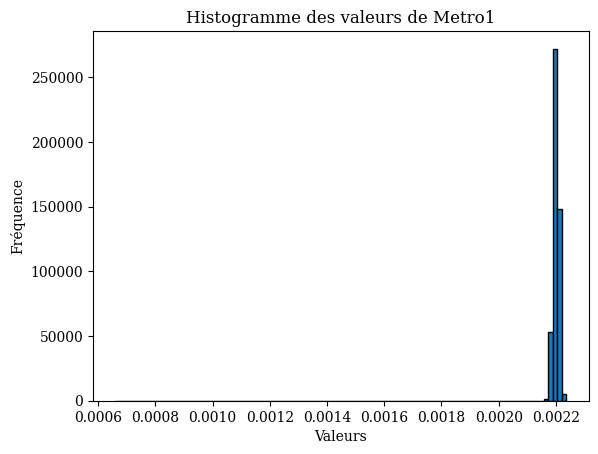

In [116]:

# Écrire les premières valeurs dans un fichier
with open('HS_values_Dm2.txt', 'w') as fichier:
    for array in Metro:
        fichier.write(f"{array[1]}\n")

# Lire les valeurs depuis le fichier
valeurs = []
with open('HS_values_Dm2.txt', 'r') as fichier:
    lignes = fichier.readlines()
    for ligne in lignes:
        valeurs.append(float(ligne.strip()))

# Tracer l'histogramme
plt.hist(valeurs, bins=100, edgecolor='black')
plt.title('Histogramme des valeurs de Metro1')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


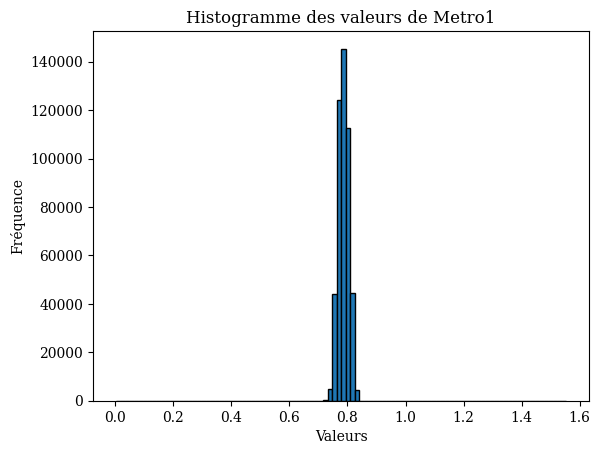

In [117]:
# Écrire les premières valeurs dans un fichier
with open('HS_values_theta.txt', 'w') as fichier:
    for array in Metro:
        fichier.write(f"{array[0]}\n")

# Lire les valeurs depuis le fichier
valeurs = []
with open('HS_values_theta.txt', 'r') as fichier:
    lignes = fichier.readlines()
    for ligne in lignes:
        valeurs.append(float(ligne.strip()))

# Tracer l'histogramme
plt.hist(valeurs, bins=100, edgecolor='black')
plt.title('Histogramme des valeurs de Metro1')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

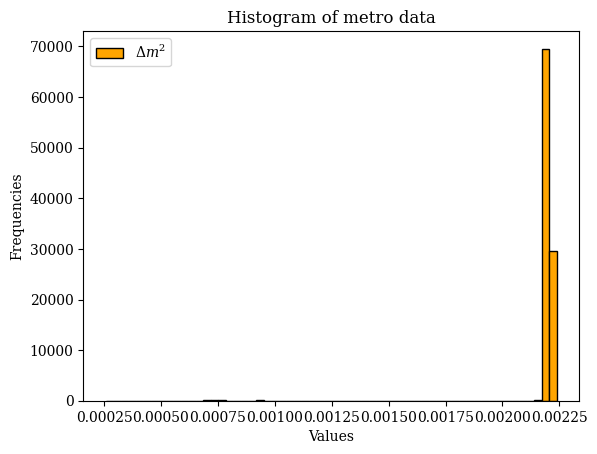

In [60]:
Metro_1= plt.hist([m[1] for m in Metro1], bins=60, edgecolor='black',color=['orange'], label=[r'$\Delta m^2$'])
# Ajouter des titres et des étiquettes
plt.title('Histogram of metro data')
plt.xlabel('Values')
plt.ylabel('Frequencies')

# Définir les limites de l'axe des abscisses

plt.legend()
# Afficher l'histogramme
plt.savefig('Histo_Dm2_1000000.png')
plt.show()

In [59]:
print(f"Le nombre de coup max pour la valeur de θ est {np.max(Metro_0[0])}")
print(f"Le nombre de coup max pour la valeur de Δm² est {np.max((Metro_1[0]))}")


for i in range(len(Metro_0[0])):
   if Metro_0[0][i] == np.max(Metro_0[0]) :
        print(i)
for i in range(len(Metro_1[0])):
    if Metro_1[0][i] == np.max(Metro_1[0]) :
        print(i)
print('Elle vaut θ = ' + str(Metro_0[1][11]))
print('Elle vaut Δm² = ' +str(Metro_1[1][588]))

Le nombre de coup max pour la valeur de θ est 4559.0
Le nombre de coup max pour la valeur de Δm² est 14099.0
11
588
Elle vaut θ = -0.7933487192731447
Elle vaut Δm² = 0.002198168556162833


# Représention à 2 dimensions

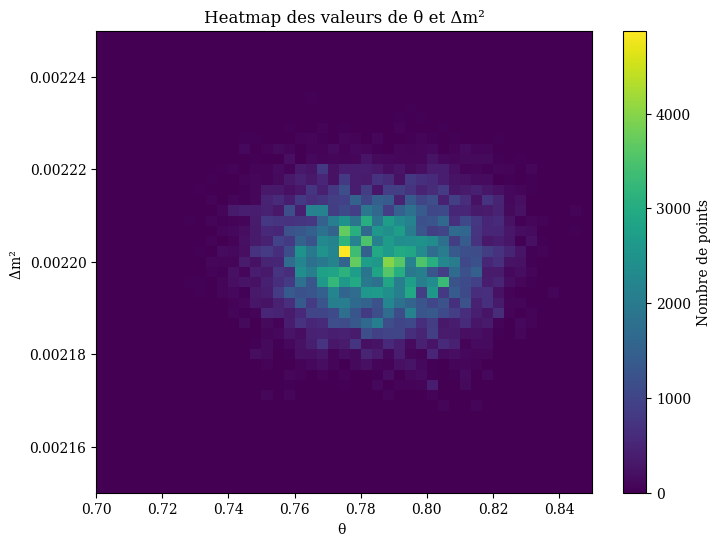

In [119]:
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, img = plt.hist2d([m[0] for m in Metro], [m[1] for m in Metro], bins=45, cmap='viridis', range=[[0.7, 0.85], [0.00215, 0.00225]])

# Ajout d'une barre de couleur
plt.colorbar(label='Nombre de points')

# Titres et labels des axes
plt.title('Heatmap des valeurs de θ et Δm²')
plt.xlabel('θ ')
plt.ylabel('Δm² ')

# Affichage de la heatmap
plt.savefig('HeatMap_Test0.png')
plt.show()

In [ ]:
len(evt_rate_osc_true)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
theta_true = np.pi/4
Dm2_true = 2.2e-3

# Generate some synthetic data from the model.
N = 50
x = [i for i in range(137)]
yerr = 0.1 + 0.5 * np.random.rand(N)
y = [evt_rate_osc_true[i] for i in range(137)]



plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
len(evt_rate_osc_true)

**2.3.2 Acceptance function**

The acceptance function returns if the step is accepted or not according to the Metropolis-Hastings ratio $r_i$ and following the properties: 
- $r_i \geq 1 \ \rightarrow $ the step is accepted
- $r_i < 1 \ \rightarrow $: a random number is thrown and: 
    - the step is accepted if  $r_i \geq U(0,1)$ 
    - the step is rejected if $r_i < U(0,1)$



In [ ]:
### Compute the acceptance function 


### 2.4 Start the Markov Chain



**2.4.1 Intitialise the chain**

We throw the first step $\theta_0, \Delta m^2_0$ and compute the corresponding posterior probability $P(\theta_0, \Delta m^2_0| D)_{un}$.


In [ ]:
### Create container arrays for values


In [ ]:
### Throw the first step


**2.4.2 Run the Markov Chain**

We run the Markov Chain for $N=10^6$ steps.

In [ ]:
# Run the MCMC


In [ ]:
# Save the output in a csv file

## 3. Analyse the Markov Chain output



### 3.1 The trace

The trace is the value of the sampled parameters as a function of the step. We use it to remove the steps sampled before the chained has converged.

In [ ]:
### Plot the MCMC trace
plt.plot([m[0] for m in Metro0[:2000]], alpha=0.7, label=r'$\theta$')

In [ ]:
plt.plot([m[1] for m in Metro1],alpha=0.7,label= r'$\Delta m^2$')

In [ ]:
### Remove burn-in, i.e. samples before convergence

burnin = 1000

### 3.2 The sampled  distribution

The $\{ \theta_i, \Delta m^2_i \}$ samples are proportional to the posterior distribution $P(\theta,  \Delta m^2 | D)$. 
We will plot their distribution and take the mode as the most probable value.
If the histogram is not smooth enough, is can either been smoothed with an interpolation function or more steps can be added to the chain. 


In [ ]:
### Plot the parameters samples - 2D histogram


In [ ]:
### Get the mode of the posterior distribution


In [ ]:
### Compare the fluxes
